In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

RDKit WARNING: [14:58:50] Enabling RDKit 2020.03.1dev1 jupyter extensions


'/net/pulsar/home/koes/mtr22/gan'

In [2]:
def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [25]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [53]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [43]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [47]:
line_idx, n_lines, pct_done

(725033, 725033, 100.0)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


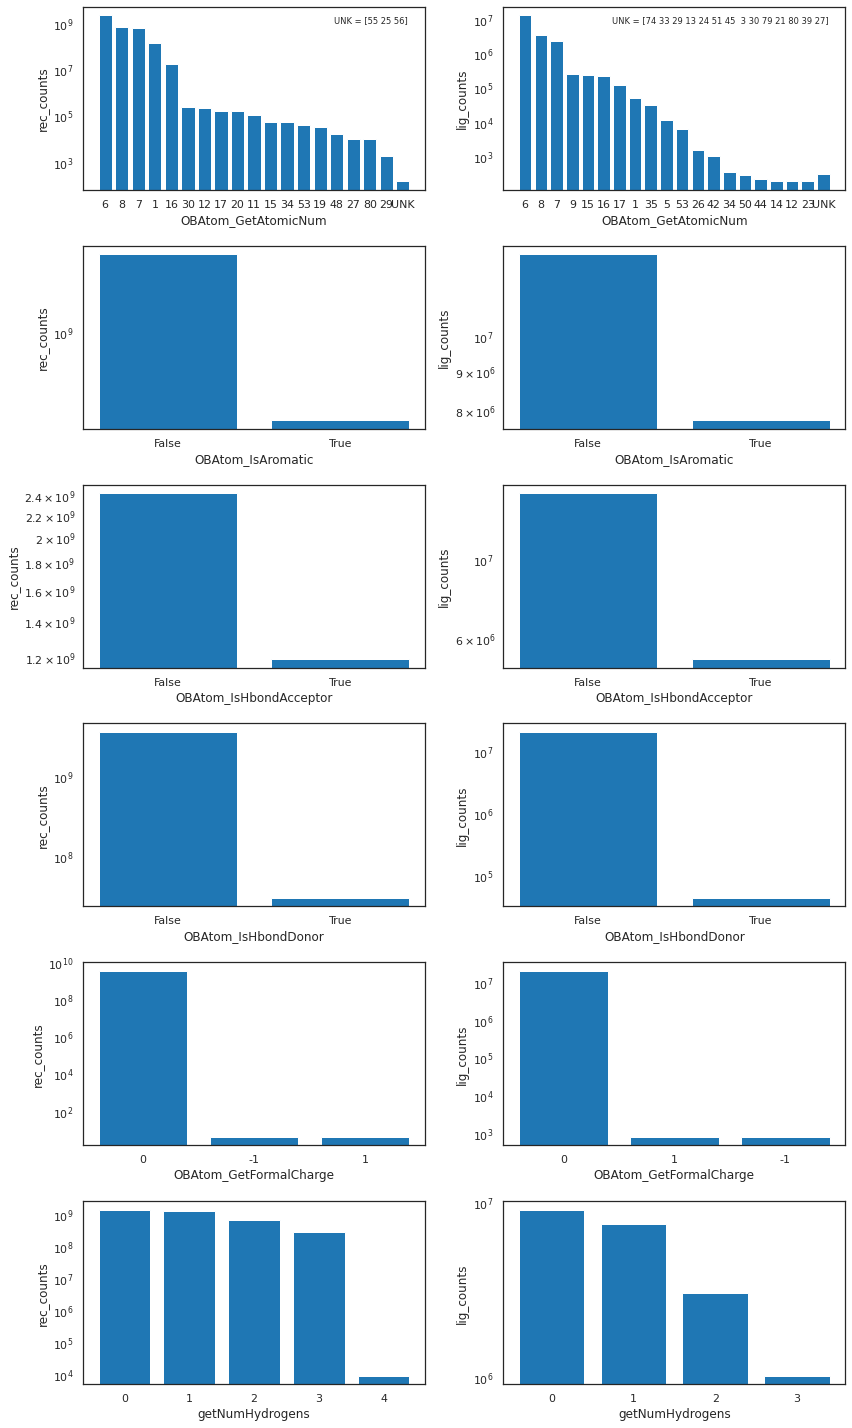

In [54]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [138]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
25	Mn	1.39	2.05
27	Co	1.26	2.0
29	Cu	1.32	2.0
30	Zn	1.22	2.1
34	Se	1.2	1.9
48	Cd	1.44	2.2
53	I	1.39	1.98
55	Cs	2.44	3.43
56	Ba	2.15	2.68
80	Hg	1.32	2.05


# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [6]:
os.chdir(add_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [3]:
add_params = param_search.ParamSpace(
    data_root = '/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file = '/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples = 100000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol = [0, 1],
    remove_h = [0, 1],
)
len(add_params)

20

In [4]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_onc_0_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_onc_0_1/add.sh',
 '/net

In [748]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

[6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012]


In [5]:
add_df = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [6]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

,,runtime,node_id,job_state,stdout,stderr
job_id,job_name,,,,,
6816993,add_oad_0_0,NaN,NaN,OK,None,None
6816994,add_oad_0_1,NaN,NaN,OK,None,None
6816995,add_oad_1_0,NaN,NaN,OK,None,None
6816996,add_oad_1_1,NaN,NaN,OK,None,None
6816997,add_oadc_0_0,NaN,NaN,OK,None,None
6816998,add_oadc_0_1,NaN,NaN,OK,None,None
6816999,add_oadc_1_0,NaN,NaN,OK,None,None
6817000,add_oadc_1_1,NaN,NaN,OK,None,None
6817001,add_on_0_0,NaN,NaN,OK,None,None


In [7]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

,example_idx
job_name,
add_oad_0_0,100000
add_oad_0_1,100000
add_oad_1_0,100000
add_oad_1_1,100000
add_oadc_0_0,100000
add_oadc_0_1,100000
add_oadc_1_0,100000
add_oadc_1_1,100000
add_oh_0_0,90903


In [929]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['remove_h'] == 0) &
    (plot_df['typer_fns'] == 'on')
]
plot_df.groupby(
    ['use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

lig_name               
lig_reason invalid valence valid molecule
use_ob_mol                               
0                    8.556         91.444
1                    8.556         91.444

oad  = H acceptor/donor
oadc = H acceptor/donor + formal charge
on   = H count
onc  = H count + formal charge
oh   = explicit H atoms


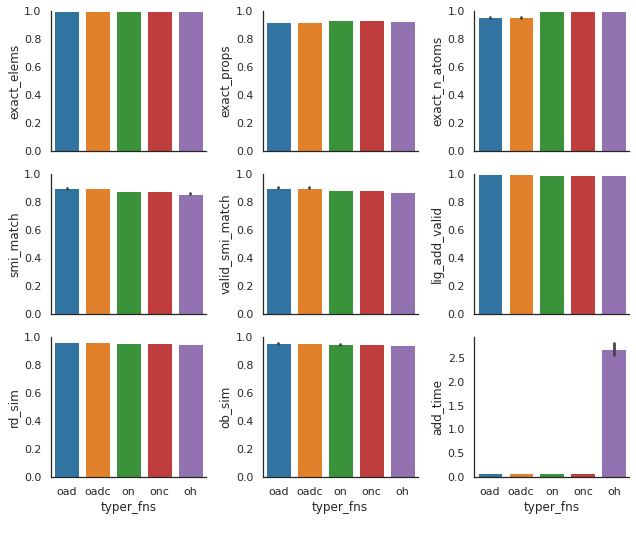

In [930]:
typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        'smi_match',
        'valid_smi_match',
        'lig_add_valid',
        'rd_sim',
        'ob_sim',
        'add_time'
    ],
    hue=None,
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=sns.barplot,
    ylim=dict(
        exact_elems=[0, 1],
        exact_props=[0, 1],
        exact_n_atoms=[0, 1],
        smi_match=[0, 1],
        lig_valid=[0, 1],
        lig_add_valid=[0, 1],
        valid_smi_match=[0, 1],
        rd_sim=[0, 1],
        ob_sim=[0, 1],
    )
)

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'onc', 'oh']
))

In [910]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

,exact_elems,exact_props,exact_n_atoms,smi_match,lig_valid,lig_add_valid,valid_smi_match,rd_sim,ob_sim,add_time
typer_fns,,,,,,,,,,
oad,100.0,91.950265,95.175189,89.561918,100.0,99.556012,89.961335,95.862544,95.119493,7.462372
oadc,100.0,91.994007,95.218932,89.605660,100.0,99.556012,90.005273,95.880239,95.138715,7.459011
oh,100.0,92.748352,100.000000,85.723690,100.0,98.807577,86.758215,94.933465,93.792281,264.399479
on,100.0,93.187087,100.000000,87.518044,100.0,99.128428,88.287533,95.449100,94.414024,7.398175
onc,100.0,93.193649,100.000000,87.561786,100.0,99.128428,88.331660,95.465724,94.434357,7.216748


In [911]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

,valid molecule
typer_fns,
oad,100
oadc,100
oh,100
on,100
onc,100


In [912]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

,valid molecule,invalid valence,multiple fragments
typer_fns,,,
oad,99.556012,0.443988,0.000000
oadc,99.556012,0.443988,0.000000
oh,98.807577,1.063440,0.128983
on,99.128428,0.871572,0.000000
onc,99.128428,0.871572,0.000000


In [890]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

,index,example_idx,lig_name,pose_idx,elem_count_diff,prop_count_diff,n_atoms_diff,lig_smi,lig_valid,lig_reason,lig_add_smi,lig_add_valid,lig_add_reason,smi_match,rd_sim,ob_sim,add_time,data_root,data_file,n_examples,typer_fns,use_ob_mol,remove_h,job_name,exact_elems,exact_props,exact_n_atoms,valid_smi_match
800002,2,2,3el8_B_rec_4fic_0ul_lig_tt_docked,13,0,0,0,NC1=NC2C=NC(c3ccccc3)=CN2N1,True,valid molecule,NC1=NC2[CH]N=C(c3ccccc3)[CH]N2N1,True,valid molecule,False,0.3817,0.3316,0.0262,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800003,3,3,3rwq_A_rec_3qcq_3q0_lig_tt_docked,0,0,0,0,CCNc1cc(C2=CC3=NN=C(N)C3=CC2)nc(N)n1,True,valid molecule,CCNc1cc(C2=CC3=C([CH]C2)[C](N)N=N3)nc(N)n1,True,valid molecule,False,0.5910,0.4957,0.0398,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800010,10,10,1c88_A_rec_3cwe_825_lig_tt_min,0,0,0,0,O=C(c1ccccc1)C(Cc1ccc(C(F)(F)P(=O)(O)O)c(Br)c1...,True,valid molecule,OC(F)(F)(c1c(Br)cc(CC(C(=O)c2ccccc2)c2ccccc2)c...,False,invalid valence,False,NaN,NaN,0.0706,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,NaN
800054,54,54,4kbn_A_rec_5hsr_63y_lig_tt_docked,18,0,0,0,FC1=C(F)C2C3(C(=S)C1)C14SC1CC(F)=C(F)C243,True,valid molecule,[C]CC(F)=C(F)C([C]SC#C)[C]1SCC(F)=C1F,True,valid molecule,False,0.5117,0.4419,0.0372,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
800077,77,77,3cov_A_rec_3iub_fg2_lig_tt_min,0,0,0,0,COC1=CCC2=NC(C(=O)NS(=O)(=O)c3ccc(C)cn3)=CC2=C1,True,valid molecule,COC1=CC2=C(C[CH]1)N=C(C(=O)NS(=O)(=O)c1ccc(C)c...,True,valid molecule,False,0.5912,0.5037,0.0450,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899921,99921,99921,3unc_B_rec_3unc_mos_lig_tt_docked,0,0,0,0,O[Mo](O)S,True,valid molecule,O[SH][OH][Fe],False,invalid valence,False,NaN,NaN,0.0040,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,NaN
899928,99928,99928,5uwm_A_rec_5boy_4ue_lig_tt_docked,0,0,0,0,CCOC(=O)C1=NC2C=CC(c3cncn3C)=CC2=C1,True,valid molecule,CCOC(=O)C1=NC2C=C[C](c3cncn3C)C=C2[CH]1,True,valid molecule,False,0.5496,0.5256,0.0373,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
899940,99940,99940,4ajf_A_rec_5edh_5mf_lig_tt_docked,2,0,0,0,CCC1=C2N=C(CCc3nc(N4CCCC4)nn3C)NN2C(C)N=C1,True,valid molecule,CCC1=C[N]C(C)N2N[C](CCc3nc(N4CCCC4)nn3C)N=C12,True,valid molecule,False,0.6550,0.6038,0.0571,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0
899986,99986,99986,4bzn_A_rec_4wt6_3u6_lig_tt_docked,1,0,0,0,Nc1nnc(-c2ccc3c(c2)=C(c2cccc(NC4CCCC4)n2)CN=3)s1,True,valid molecule,Nc1nnc(-c2ccc3c(c2)[C](c2cccc(NC4CCCC4)n2)C[N]...,True,valid molecule,False,0.5588,0.5874,0.0666,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,on,0,0,add_on_0_0,True,True,True,0.0


# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [8]:
fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting'

In [9]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

12

In [10]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oh-1.0_0/generate.sh',
 

In [756]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

[6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024]


In [11]:
fit_df = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [12]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

,,runtime,node_id,job_state,stderr
job_id,job_name,,,,
6817013,fit_oad-0.5_0,5-22:17:34,g007,R,None
6817014,fit_oad-1.0_0,5-22:17:34,g007,R,None
6817015,fit_oad-1.5_0,5-22:17:34,g007,R,None
6817016,fit_oadc-0.5_0,5-22:17:34,g001,R,None
6817017,fit_oadc-1.0_0,5-22:17:34,g002,R,None
6817018,fit_oadc-1.5_0,5-22:17:34,g002,R,None
6817019,fit_on-0.5_0,5-22:17:34,g002,R,None
6817020,fit_on-1.0_0,5-22:17:34,g003,R,None
6817021,fit_on-1.5_0,5-22:17:34,g003,R,None


In [13]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-1.0_0/generate.sh No columns to parse from file


,sample_idx
job_name,
fit_oad-0.5_0,84830
fit_oad-1.0_0,85850
fit_oad-1.5_0,84300
fit_oadc-0.5_0,80780
fit_oadc-1.0_0,80810
fit_oadc-1.5_0,79610
fit_oh-0.5_0,71140
fit_oh-1.0_0,72680
fit_oh-1.5_0,72330


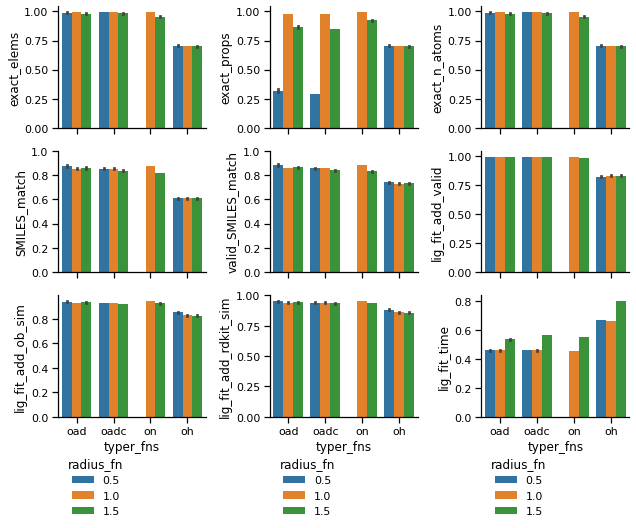

In [24]:
def my_plot(*args, **kwargs):
    return sns.barplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [21]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

valid molecule  invalid valence  multiple fragments
typer_fns radius_fn                                                     
oad       0.5             99.613506         0.382184            0.004310
          1.0             99.428983         0.569575            0.001442
          1.5             99.458714         0.539835            0.001451
oadc      0.5             99.604416         0.389451            0.006133
oh        0.5             80.914384        15.904110            3.181507
          1.0             82.275689        15.650794            2.073517
          1.5             82.271198        17.392328            0.336474
on        0.5             98.193671         1.803399            0.002930
          1.0             98.209613         1.790387            0.000000
          1.5             97.691480         2.305444            0.003076

(0.0, 23.5)

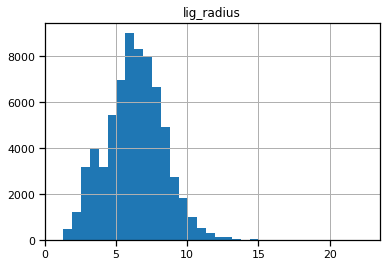

In [135]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

,lig_radius,lig_fit_n_atoms_diff
lig_radius,1.000000,0.167517
lig_fit_n_atoms_diff,0.167517,1.000000


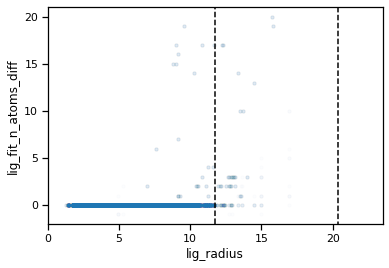

In [133]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids, then test molecule reconstruction using atom fitting + bond adding.

[Table of contents](#Table-of-contents)

In [3]:
train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [14]:
# train1 group (single receptor)
train_params = list(param_search.ParamSpace(
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_2j34_B.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_2j34_B.types',
    model_type=['CVAE'],
    typer_fns=['on'],
    radius_fn=[1.0],
    n_latent=[128, 256],
    gen_spectral_norm=[0],
    optim_type='RMSprop',
    gen_lr=[1e-4, 1e-5, 1e-6],
    disc_lr=[0],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
    group_name='1',
    sbatch_line='',
    gen_iteration=100000,
)) + list(param_search.ParamSpace(
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_2j34_B.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_2j34_B.types',
    model_type=['CVAEGAN', 'CGAN'],
    typer_fns=['on'],
    radius_fn=[1.0],
    n_latent=[128, 256],
    gen_spectral_norm=[0],
    optim_type='RMSprop',
    gen_lr=[1e-4, 1e-5, 1e-6],
    disc_lr=[1e-4, 1e-5],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
    group_name='1',
    sbatch_line='',
    gen_iteration=100000,
))

name_format = 'train{group_name}_{model_type}_{typer_fns}-{radius_fn}_{n_latent}_{gen_lr:.1e}_{disc_lr:.1e}_{random_seed}'
len(train_params)

90

In [109]:
# train2 group (full-scale)
train_params = list(param_search.ParamSpace( # CVAE, smaller latent, no M16
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    model_type=['CVAE'],
    typer_fns=['on', 'oadc'],
    radius_fn=[1.0],
    n_latent=[128, 256],
    gen_spectral_norm=[0],
    optim_type=['RMSprop'],
    gen_lr=[1e-5],
    disc_lr=[0],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
    group_name='2',
    sbatch_line=' ',
    gen_iteration=100000,
)) + list(param_search.ParamSpace( # CVAE, larger later, require M16
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    model_type=['CVAE'],
    typer_fns=['on', 'oadc'],
    radius_fn=[1.0],
    n_latent=[512, 1024],
    gen_spectral_norm=[0],
    optim_type=['RMSprop'],
    gen_lr=[1e-5],
    disc_lr=[0],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
    group_name='2',
    sbatch_line='-C M16',
    gen_iteration=100000,
))

name_format = 'train{group_name}_{model_type}_{typer_fns}-{radius_fn}_{n_latent}_{gen_spectral_norm}_{optim_type}_{gen_lr:.1e}_{random_seed}'
len(train_params)

24

In [15]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=train_params,
    )

assert len(set(train_job_files)) == len(train_params)
train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-04_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-06_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_256_1.0e-04_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_256_1.0e-06_0.0e+00_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-04_0.0e+00_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train1_CVAE_on-1.0_128_1.0e-06_0.0e+00_1/train.sh',
 

In [25]:
resub_job_files = ['train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_0/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_0/train.sh',
       'train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_1/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_1/train.sh',
       'train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_2/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_2/train.sh']

job_ids = param_search.submit(resub_job_files)
print(job_ids)

[6834544, 6834545, 6834546, 6834547, 6834548, 6834549]


In [4]:
train_df = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],
    ],
    group_name=[0,1,1,2,1]
)).explode('job_id')

In [5]:
%%time
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

train_df = train_df.merge(qstat, on='job_id', how='left')
train_df['work_dir'] = train_df.apply(find_work_dir, axis=1)
train_df['job_name'] = train_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_df['job_file'] = train_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_df['stdout_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_df['stderr_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_df['stdout'] = train_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
train_df['stderr'] = train_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
train_df['job_state'] = train_df.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_df['job_name'].unique())}
train_df['job_name_idx'] = train_df['job_name'].map(job_name_idx)

CPU times: user 2min 32s, sys: 6.63 s, total: 2min 39s
Wall time: 2min 45s


In [6]:
train_df[
    (train_df['group_name'] == 2) &
    #train_df['job_name'].str.contains('CVAE_') &
    #train_df['job_name'].str.contains('_1.0e-05_') &
    #(train_df['job_id'] == 6820871) &
    #(train_df['job_state'] == 'PD') &
    True
].set_index(['group_name', 'job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

runtime  \
group_name job_name                                      job_id            
2          train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0    6820935     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_0    6820936     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0  6820937     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_0  6820938     NaN   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_1    6820939     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_1    6820940     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_1  6820941     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_1  6820942     NaN   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_2    6820943     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_2    6820944     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_2  6820945     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_2  6820946     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_0    6820947     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0   6820948     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_0  6820949     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_0 6820950     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_1    6820951     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_1   6820952     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_1  6820953     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_1 6820954     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_2    6820955     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_2   6820956     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_2  6820957     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_2 6820958     NaN   

                                                                 node_id  \
group_name job_name                                      job_id            
2          train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0    6820935     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_0    6820936     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0  6820937     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_0  6820938     NaN   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_1    6820939     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_1    6820940     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_1  6820941     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_1  6820942     NaN   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_2    6820943     NaN   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_2    6820944     NaN   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_2  6820945     NaN   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_2  6820946     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_0    6820947     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0   6820948     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_0  6820949     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_0 6820950     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_1    6820951     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_1   6820952     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_1  6820953     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_1 6820954     NaN   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_2    6820955     NaN   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_2   6820956     NaN   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_2  6820957     NaN   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_2 6820958     NaN   

                                                                 job_state  \
group_name job_name              

In [7]:
resub_job_files = train_df[
    (train_df['group_name'] == 1) &
    train_df['job_name'].str.contains('CVAE_') &
    train_df['job_name'].str.contains('_1.0e-05_')
]['job_file']
resub_job_files.unique()

array(['train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_0/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_0/train.sh',
       'train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_1/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_1/train.sh',
       'train1_CVAE_on-1.0_128_1.0e-05_0.0e+00_2/train.sh',
       'train1_CVAE_on-1.0_256_1.0e-05_0.0e+00_2/train.sh'], dtype=object)

In [7]:
%%time
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
except NameError:
    pass
train_metrics = param_search.metrics(train_df[
    (train_df['group_name'] == 2)
]['job_file'], metric_pat='(.*)metrics')

CPU times: user 10.9 s, sys: 1.33 s, total: 12.3 s
Wall time: 14.3 s


In [10]:
last_iter_df = train_metrics[
    (train_metrics['data_phase'] == 'train') &
    #(train_metrics['model_phase'] != 'disc') &
    #(train_metrics['grid_phase'] != 'prior') &
    True
].sort_values('iteration').drop_duplicates('job_name', keep='last')
#.groupby('job_name').rolling(1000).mean().reset_index() \

last_iter_df.set_index(['group_name', 'job_name']).sort_values('recon_loss')

iteration  \
group_name job_name                                                   
2          train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_2       99999   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_2         99999   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_2       99999   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_2         99999   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0       99999   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_0         99999   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_1       99999   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_0       99999   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_2         99999   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_2       99999   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_0         99999   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_1         99999   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_1       99999   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_2      99999   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0        99999   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_1        99999   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_0       99999   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_2        99999   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_1         99999   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_0      99999   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_1      99999   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_1       97699   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0         99999   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_1         99999   

                                                         data_phase  batch  \
group_name job_name                                                          
2          train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_2       train      0   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_2         train      0   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_2       train      0   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_2         train      0   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0       train      0   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_0         train      0   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_1       train      0   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_0       train      0   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_2         train      0   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_2       train      0   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_0         train      0   
           train2_CVAE_on-1.0_512_0_RMSprop_1.0e-05_1         train      0   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_1       train      0   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_2      train      0   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0        train      0   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_1        train      0   
           train2_CVAE_oadc-1.0_512_0_RMSprop_1.0e-05_0       train      0   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_2        train      0   
           train2_CVAE_on-1.0_256_0_RMSprop_1.0e-05_1         train      0   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_0      train      0   
           train2_CVAE_oadc-1.0_1024_0_RMSprop_1.0e-05_1      train      0   
           train2_CVAE_oadc-1.0_256_0_RMSprop_1.0e-05_1       train      0   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0         train      0   
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_1         train      0   

                                                                loss  \
group_name job_name                                                    
2          train2_CVAE_oadc-1.0_128_0_

In [18]:
plot_df['n_latent'].dtype

dtype('int64')

In [35]:
for typer_fns in ['oadc', 'on']:
    t = liGAN.atom_types.AtomTyper.get_typer(typer_fns, 1, device='cpu')
    print(typer_fns, t.n_types, t.n_elem_types, t.n_prop_types, [len(r) for r in t.prop_ranges])

oadc 18 11 7 [11, 2, 1, 1, 3]
on 18 11 7 [11, 2, 5]


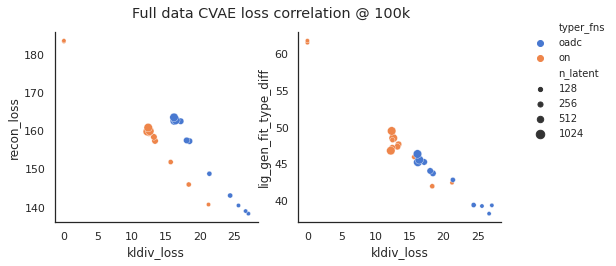

In [92]:
import param_search
sns.set_palette('muted')
plot_df = train_metrics #last_iter_df
plot_df = plot_df[
    (plot_df['group_name'] == '2') &
    (plot_df['model_type'] == 'CVAE') &
    (plot_df['iteration'] >= (100000-1000)) &
    True
].groupby(['typer_fns', 'model_type', 'n_latent', 'gen_lr', 'disc_lr', 'random_seed']).mean().reset_index().sort_values('recon_loss')

#plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())

fig = param_search.plot(
    plot_df,
    x=['kldiv_loss'],# 'gan_loss', 'log_abs_gan_loss'],
    y=['recon_loss','lig_gen_fit_type_diff'],
    hue='typer_fns',
    n_cols=3,
    width=4,
    height=3.5,
    plot_func=sns.scatterplot,
    plot_kws=dict(size='n_latent'),
    ylim=dict(),
    xlim=dict(),
    legend_kws=dict(
        fontsize='small',
        title=False,
        title_fontsize='medium',
        bbox_to_anchor=(1.1, 1.1),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)

fig.suptitle('Full data CVAE loss correlation @ 100k', y=0.98)
fig.savefig('plots/train2_CVAE_loss_corr_plot.png')

In [92]:
# estimate memory usage
KB = 1024
MB = 1024**2
GB = 1024**3

dfs = dict()
df_names = dict()

for name, df in list(locals().items()):
    if isinstance(df, pd.DataFrame):
        if id(df) not in df_names:
            dfs[id(df)] = df
            df_names[id(df)] = []
        df_names[id(df)].append(name)

total_mem = 0
for df_id in dfs:
    df_mem = dfs[df_id].memory_usage(index=True, deep=True).sum() / GB
    print(df_names[df_id], df_mem)
    total_mem += df_mem
    
print(total_mem)

['train_df'] 0.0002810731530189514
['qstat'] 8.204206824302673e-05
['_8'] 3.1422823667526245e-05
['_33'] 0.0
['_34'] 0.0
['train_metrics'] 19.618055798113346
['last_iter_df'] 4.370883107185364e-05
['_53'] 4.1875988245010376e-05
['plot_df'] 2.9381364583969116e-05
19.618565302342176


In [104]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

iter_bin_size = 1000
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics
#plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    #'log_abs_gan_loss',
    #'gan_loss',
    
    'lig_norm',
    'lig_gen_norm',
    'gen_grad_norm',
    
    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    #'disc_grad_norm',
    
    'lig_variance',
    'lig_gen_variance',
]
train_x = 'iter_bin'

In [105]:
colors = sns.color_palette(
    sorted(3*sns.color_palette('Blues_r', 4)) + sorted(3*sns.color_palette('Oranges_r', 4))
)
assert len(colors) == 24
sns.set_palette(colors)
colors

[(0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
 (0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
 (0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
 (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
 (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
 (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
 (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
 (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
 (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
 (0.8141176470588235, 0.883921568627451, 0.9498039215686275),
 (0.8141176470588235, 0.883921568627451, 0.9498039215686275),
 (0.8141176470588235, 0.883921568627451, 0.9498039215686275),
 (0.7709803921568628, 0.2541176470588235, 0.007058823529411764),
 (0.7709803921568628, 0.2541176470588235, 0.007058823529411764),
 (0.7709803921568628, 0.2541176470588235, 0.007058823529411764),
 (0.9545098039215686, 0.44, 0.10666666666666666),
 (0.9545098039215686, 0.44, 0.10666666666666666),
 (0.9545098039215686, 0.44, 0.10666666666666666),
 (0.9921568627450981, 0.6564705882352941, 0.3827450980392157),
 (0.9921568627450981, 0.6564705882352941, 0.3827450980392157),
 (0.9921568627450981, 0.6564705882352941, 0.3827450980392157),
 (0.9937254901960785, 0.8501960784313726, 0.7043137254901961),
 (0.9937254901960785, 0.8501960784313726, 0.7043137254901961),
 (0.9937254901960785, 0.8501960784313726, 0.7043137254901961)]

CPU times: user 47.3 s, sys: 4.36 s, total: 51.6 s
Wall time: 51.6 s


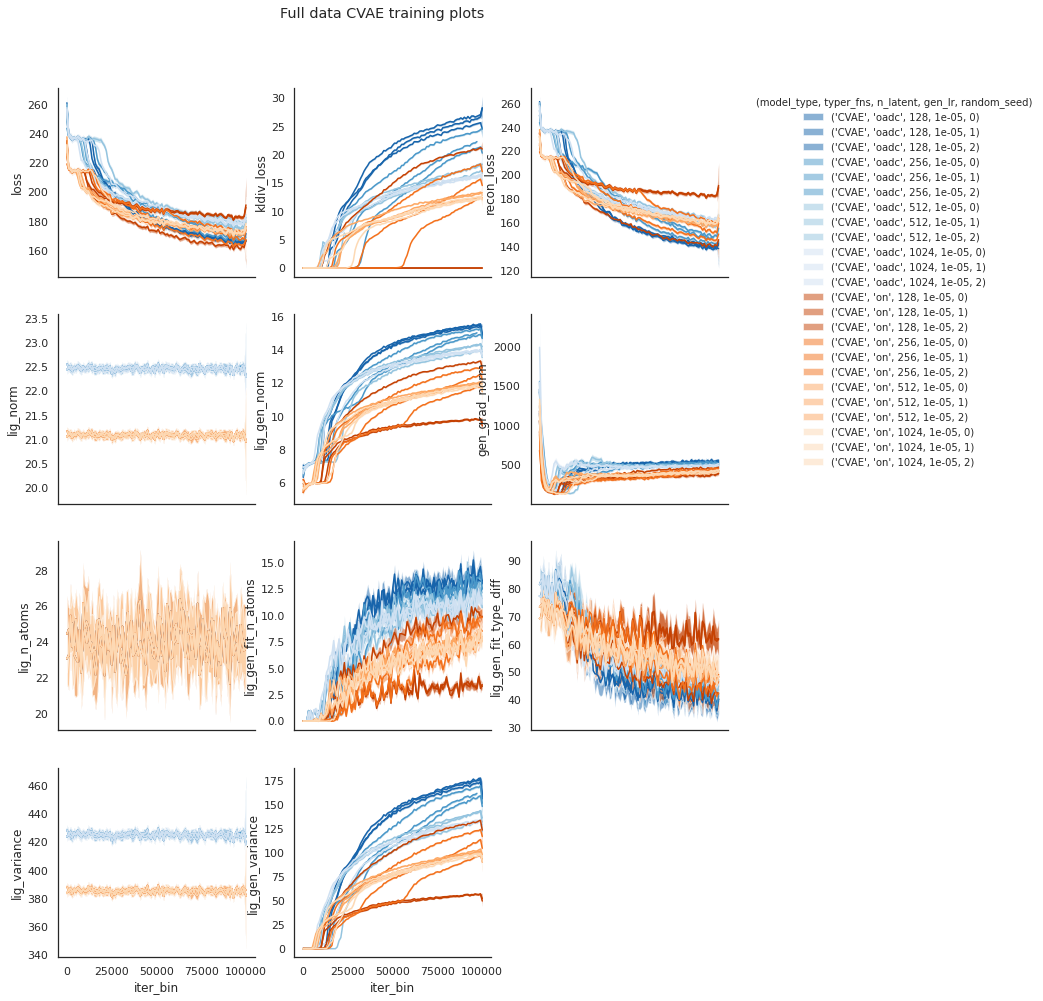

In [110]:
%%time

# everthing but random_seed
hue = ['model_type', 'typer_fns', 'n_latent', 'gen_lr', 'random_seed']

fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '2') &
        (plot_df['model_type'] == 'CVAE') &
        (plot_df['loss'].abs() < 1e8) &
        True
    ].sort_values(hue),
    x=train_x,
    y=train_y,
    hue=hue, 
    n_cols=3,
    width=4,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='small',
        bbox_to_anchor=(1.1, 1.00),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)
fig.suptitle('Full data CVAE training plots', y=0.95)
fig.savefig('plots/train2_CVAE_training_plots.png')

In [53]:
train_metrics.columns

Index(['iteration', 'data_phase', 'batch', 'loss', 'recon_loss', 'kldiv_loss',
       'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance',
       ...
       'job_name', 'disc_iter', 'model_phase', 'grid_phase', 'gan_loss',
       'pred_mean', 'pred_variance', 'forward_disc_time', 'disc_grad_norm',
       'iter_bin'],
      dtype='object', length=155)

forward_data_time       0.037880
forward_gen_time        0.035961
forward_fit_time        0.035926
forward_metrics_time    0.002479
forward_time            0.220974
dtype: float64

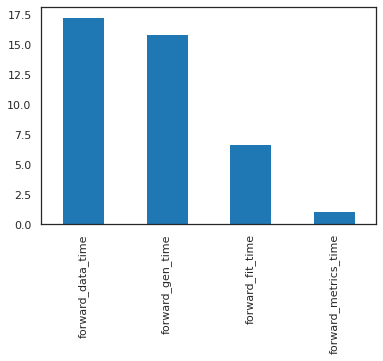

In [54]:
time_cols = ['forward_data_time', 'forward_gen_time', 'forward_fit_time', 'forward_metrics_time', 'forward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
plot_df = (plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

backward_grad_time      0.005771
backward_norm_time      0.025898
backward_update_time    0.003858
backward_time           0.035528
dtype: float64

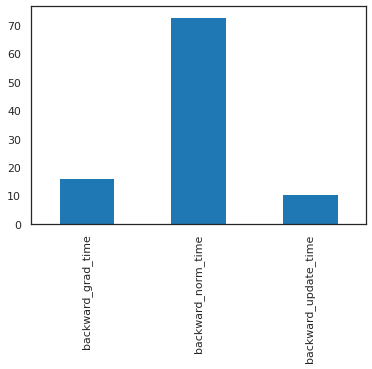

In [55]:
time_cols = ['backward_grad_time', 'backward_norm_time', 'backward_update_time', 'backward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
(plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

In [ ]:
locals()